In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [29]:
df = pd.read_csv('../data/dataset/freesolv.csv')

In [30]:
df.columns

Index(['iupac', 'smiles', 'expt', 'calc'], dtype='object')

In [31]:
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


In [33]:
smiles = df['smiles']
print(smiles.iloc[23])

COC(=O)C1CC1


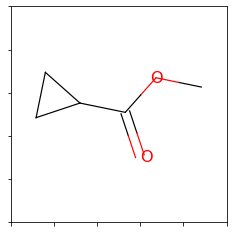

In [34]:
smiles = df['smiles']
m = Chem.MolFromSmiles(smiles.iloc[23])
fig = Draw.MolToMPL(m, size=(120, 120))

In [15]:
all_atom_names = []
all_hydrogens = []

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogens = [a.GetImplicitValence() for a in m.GetAtoms()]
    all_atom_names += atom_names
    all_hydrogens += hydrogens
    
atom_dict = {}
for i, a in enumerate(list(Counter(all_atom_names))):
    atom_dict[a] = i
    
max_hydrogen = max(Counter(all_hydrogens).keys())

4


In [25]:
node_data = []
adj_data = []
target_data = []

expt = df['expt']

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogen_nums = [a.GetImplicitValence() for a in m.GetAtoms()]
    
    node = []
    for j, (a, h) in enumerate(zip(atom_names, hydrogen_nums)):
        node_atom_names = np.zeros(len(atom_dict))
        node_hydrogens = np.zeros(max_hydrogen+1)
        
        node_atom_names[atom_dict[a]] += 1
        node_hydrogens[h] += 1
        node.append(node_atom_names)
    node = np.array(node)
        
    adj = GetAdjacencyMatrix(m)
    
    node_data.append(torch.from_numpy(node).float())
    adj_data.append(torch.from_numpy(adj + np.eye(len(adj))).float())
    target_data.append(torch.FloatTensor([expt[i]]))

In [26]:
dataset = []
dataset.append(node_data)
dataset.append(adj_data)
dataset.append(target_data)

In [27]:
torch.save(dataset, '../dataset/freesolv.pt')